<a href="https://colab.research.google.com/github/asyhar22/kalbe_farma_ds/blob/main/VIX_Kalbe_Nutritionals_Prophet_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

In [1]:
!pip install prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

##Data

In [3]:
df = pd.read_excel("https://github.com/asyhar22/kalbe_farma_ds/raw/main/DATA/merged_data.xlsx", index_col=[2], parse_dates=[2])
df = df.groupby('Date')['Qty'].sum()
df = pd.DataFrame(df)
df.head()

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


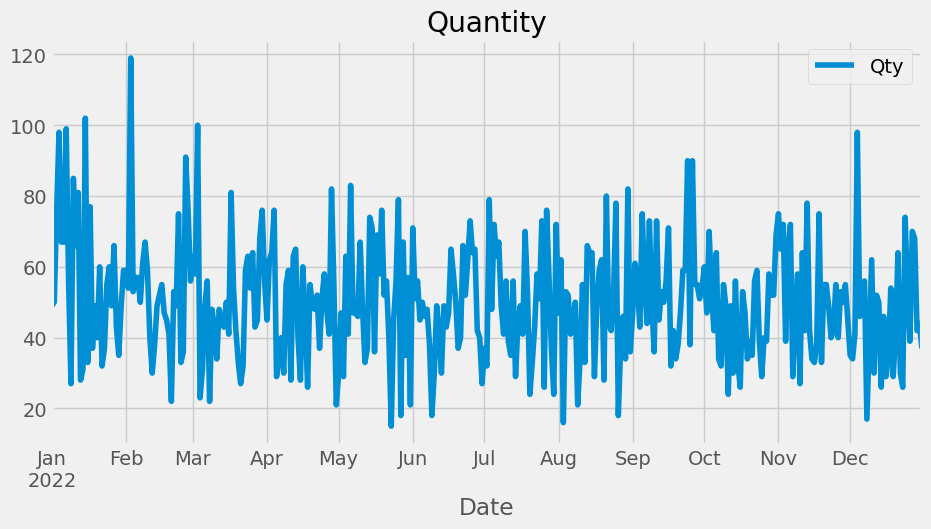

In [4]:
df.plot(figsize=(10,5),
        title='Quantity')
plt.show()

##Tiem Series Features

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['date','hour','dayofweek','weekday','quarter','month','year','dayofyear','dayofmonth','weekofyear']]

    if label:
      y = df['Qty']
      return X, y
    return X

X, y = create_features(df, label='Qty')
features_and_target = pd.concat([X,y], axis=1)

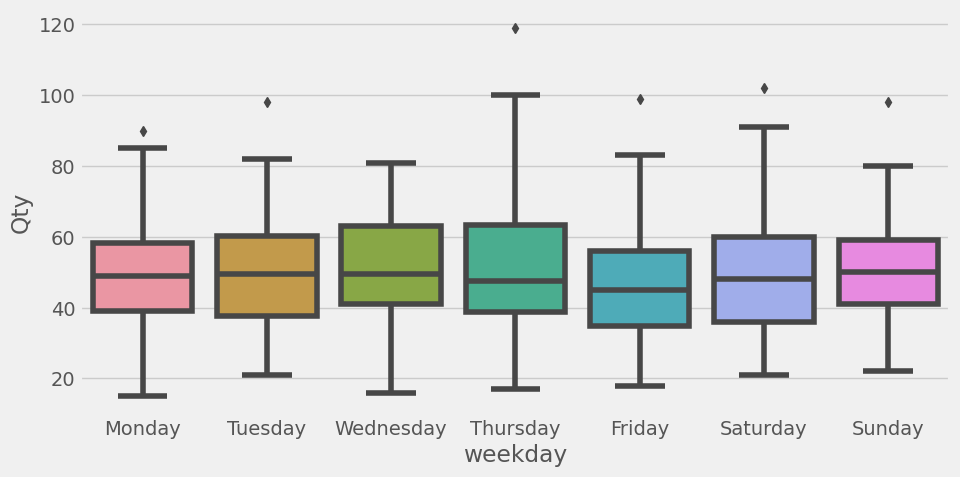

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target,
            x='weekday',
            y='Qty',
            ax=ax,
            )
plt.show()

## Train Test Split

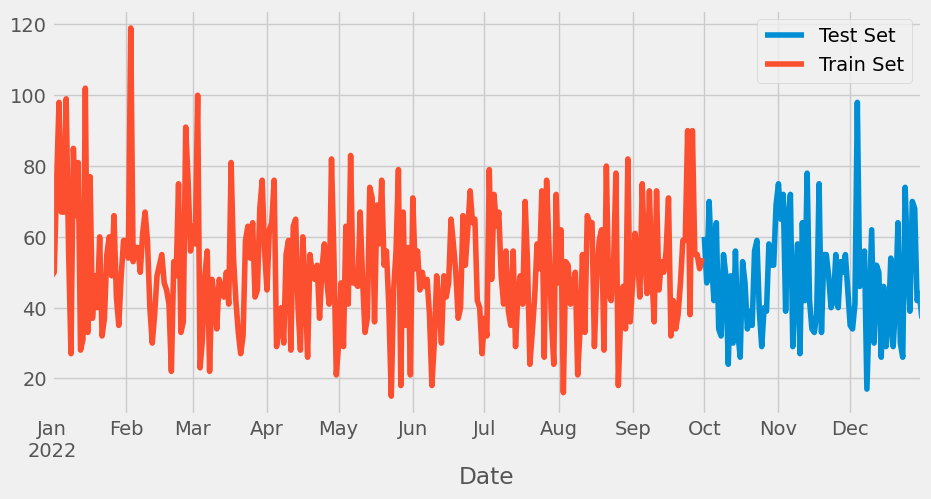

In [7]:
split_date = '2022-10-01'
df_train = df.loc[df.index < split_date].copy()
df_test = df.loc[df.index >= split_date].copy()

df_test.rename(columns={'Qty':'Test Set'}).join(df_train.rename(columns={'Qty':'Train Set'}), how='outer').plot(figsize=(10,5))

plt.show()

## Simple Model

In [8]:
df_train_prophet = df_train.reset_index().rename(columns={'Date':'ds','Qty':'y'})

In [9]:
%%time
model = Prophet()
model.fit(df_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr9z0k2da/_h_b33_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr9z0k2da/ro10_v2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7329', 'data', 'file=/tmp/tmpr9z0k2da/_h_b33_g.json', 'init=/tmp/tmpr9z0k2da/ro10_v2y.json', 'output', 'file=/tmp/tmpr9z0k2da/prophet_modelo8ake83j/prophet_model-20230809094836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 204 ms, sys: 19.2 ms, total: 223 ms
Wall time: 247 ms


In [10]:
df_test_prophet = df_test.reset_index().rename(columns={'Date':'ds','Qty':'y'})
df_pred = model.predict(df_test_prophet)

In [11]:
df_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-10-01,48.604241,26.784412,70.048474,48.604241,48.604241,-0.502187,-0.502187,-0.502187,-0.502187,-0.502187,-0.502187,0.0,0.0,0.0,48.102055
1,2022-10-02,48.587427,25.017349,69.683208,48.587427,48.587427,-1.356678,-1.356678,-1.356678,-1.356678,-1.356678,-1.356678,0.0,0.0,0.0,47.230750
2,2022-10-03,48.570614,27.171265,70.312163,48.570589,48.570637,0.532199,0.532199,0.532199,0.532199,0.532199,0.532199,0.0,0.0,0.0,49.102812
3,2022-10-04,48.553800,24.642412,68.606157,48.553737,48.553864,-1.142730,-1.142730,-1.142730,-1.142730,-1.142730,-1.142730,0.0,0.0,0.0,47.411070
4,2022-10-05,48.536986,28.455717,72.195293,48.536871,48.537107,1.643485,1.643485,1.643485,1.643485,1.643485,1.643485,0.0,0.0,0.0,50.180471


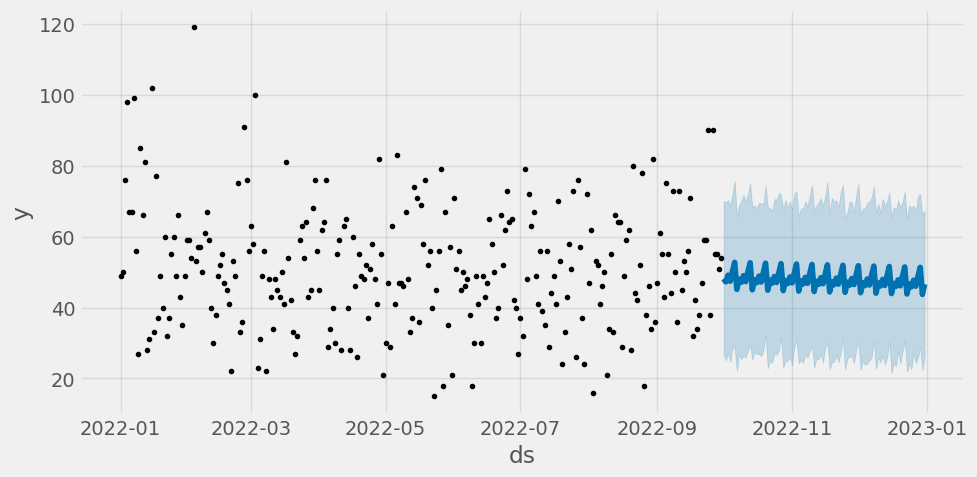

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(df_pred, ax=ax)

plt.show()

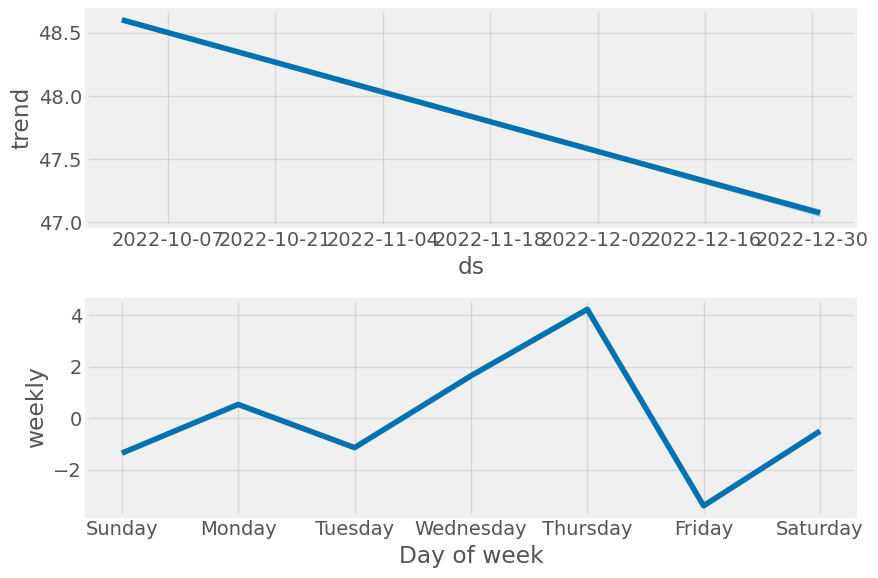

In [13]:
fig = model.plot_components(df_pred)
plt.show()

##Actual vs Forecast

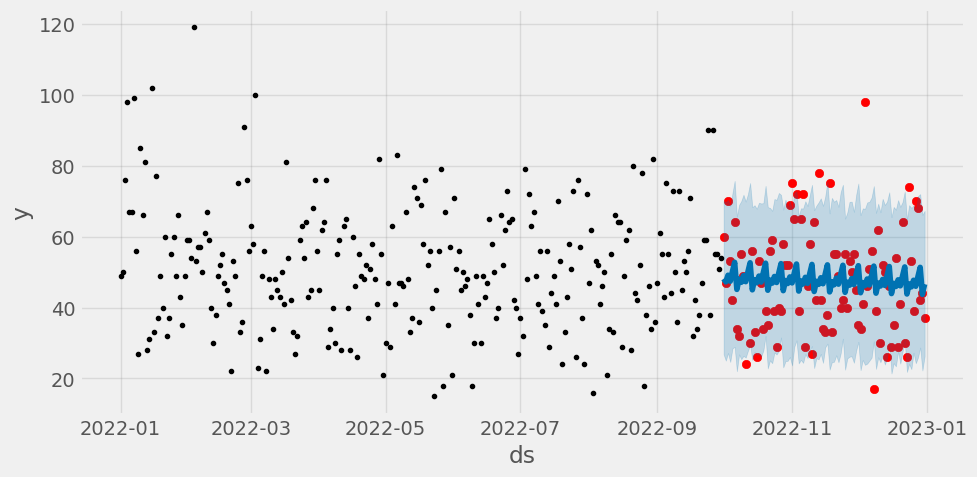

In [14]:
f, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['Qty'], color='r')
fig = model.plot(df_pred, ax=ax)

##Evaluation

In [15]:
np.sqrt(mean_squared_error(y_true=df_test['Qty'],y_pred=df_pred['yhat']))

15.387135200013612

In [16]:
mean_absolute_error(y_true=df_test['Qty'],y_pred=df_pred['yhat'])

12.631184493235645

In [17]:
mean_absolute_percentage_error(y_true=df_test['Qty'],y_pred=df_pred['yhat'])

30.430926215293834